In [1]:
import os
import json
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from PIL import Image

In [2]:
# Define directories
json_dir = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles/'
image_dir = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/'

In [3]:
data = []

# Parse each JSON file
for filename in os.listdir(json_dir):
    if filename.endswith('.json'):
        with open(os.path.join(json_dir, filename), 'r') as file:
            json_data = json.load(file)
            data.append(json_data['data'])

# Convert the list to a DataFrame
df = pd.DataFrame(data)

# Show the first few rows of the dataframe to verify
print(df.head())

      id   price  discountedPrice styleType  productTypeId articleNumber  \
0   1566   299.0            299.0         P            299         27144   
1  39342  2199.0           2199.0         P            288    81SU292201   
2  13182  2499.0           2499.0         P            288   1SB106XX010   
3  21762  1695.0           1440.0       RTV            360     MB1212001   
4  48692  1525.0           1509.0         P            416        EF8782   

  visualTag                     productDisplayName variantName  myntraRating  \
0                            Artengo Men Black Cap       Black            10   
1                        Fila Men Zoom Black Shoes     ZOOM HI             0   
2            FILA Men Dls Maxim Black Sports Shoes   Dls Maxim             1   
3                       Fossil Men Mead Black Belt        Mead             0   
4                     Lucera Women Silver Earrings      Silver             1   

   ...                                         otherFlags  \
0

In [4]:
from sklearn.preprocessing import LabelEncoder

# Columns to encode
columns_to_encode = ['gender', 'baseColour', 'season', 'usage', 'masterCategory', 'subCategory', 'articleType']

# Initialize LabelEncoders
label_encoders = {col: LabelEncoder() for col in columns_to_encode}

# Encode the columns
for col in columns_to_encode:
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

# Drop rows with missing critical values
df.dropna(subset=columns_to_encode, inplace=True)

# Show the first few rows of the dataframe to verify
print(df.head())


      id   price  discountedPrice styleType  productTypeId articleNumber  \
0   1566   299.0            299.0         P            299         27144   
1  39342  2199.0           2199.0         P            288    81SU292201   
2  13182  2499.0           2499.0         P            288   1SB106XX010   
3  21762  1695.0           1440.0       RTV            360     MB1212001   
4  48692  1525.0           1509.0         P            416        EF8782   

  visualTag                     productDisplayName variantName  myntraRating  \
0                            Artengo Men Black Cap       Black            10   
1                        Fila Men Zoom Black Shoes     ZOOM HI             0   
2            FILA Men Dls Maxim Black Sports Shoes   Dls Maxim             1   
3                       Fossil Men Mead Black Belt        Mead             0   
4                     Lucera Women Silver Earrings      Silver             1   

   ...                                         otherFlags  \
0

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Columns to encode
columns_to_encode = ['gender', 'baseColour', 'season', 'usage', 'masterCategory', 'subCategory', 'articleType']

# Initialize LabelEncoders
label_encoders = {col: LabelEncoder() for col in columns_to_encode}

# Encode the columns
for col in columns_to_encode:
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

# Drop rows with missing critical values
df.dropna(subset=columns_to_encode, inplace=True)

# Show the first few rows of the dataframe to verify
print(df.head())


In [5]:
from sklearn.cluster import KMeans

# Features for clustering
features = df[columns_to_encode]

# Using KMeans for clustering
num_clusters = 10  # Adjust the number of clusters based on your data
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Show the first few rows of the dataframe to verify
print(df.head())


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


      id   price  discountedPrice styleType  productTypeId articleNumber  \
0   1566   299.0            299.0         P            299         27144   
1  39342  2199.0           2199.0         P            288    81SU292201   
2  13182  2499.0           2499.0         P            288   1SB106XX010   
3  21762  1695.0           1440.0       RTV            360     MB1212001   
4  48692  1525.0           1509.0         P            416        EF8782   

  visualTag                     productDisplayName variantName  myntraRating  \
0                            Artengo Men Black Cap       Black            10   
1                        Fila Men Zoom Black Shoes     ZOOM HI             0   
2            FILA Men Dls Maxim Black Sports Shoes   Dls Maxim             1   
3                       Fossil Men Mead Black Belt        Mead             0   
4                     Lucera Women Silver Earrings      Silver             1   

   ...                                 articleDisplayAttr  \
0

In [8]:
import joblib

# Save the KMeans model
joblib.dump(kmeans, 'kmeans_model.pkl')

# Save the LabelEncoders
for col, le in label_encoders.items():
    joblib.dump(le, f'label_encoder_{col}.pkl')


In [6]:
def recommend_styling(product_id, occasion):
    product = df[df['id'] == product_id]
    if product.empty:
        return "Product not found."

    cluster = product['cluster'].values[0]
    occasion = label_encoders['usage'].transform([occasion])[0]

    similar_items = df[(df['cluster'] == cluster) & (df['usage'] == occasion)]

    # Exclude the input product and same category
    similar_items = similar_items[similar_items['id'] != product_id]
    similar_items = similar_items[similar_items['subCategory'] != product['subCategory'].values[0]]

    # Select a diverse set of items from different subcategories
    recommendation_set = similar_items.groupby('subCategory').apply(lambda x: x.sample(1)).reset_index(drop=True)

    return recommendation_set[['id', 'productDisplayName', 'styleImages']]




In [65]:
# Check the unique values in the usage column
print(df['usage'].unique())


In [15]:
# Example usage
product_id = 10140  # Example product ID
occasion = 'Ethnic'  # Example occasion
recommendations = recommend_styling(product_id, occasion)



/tmp/ipykernel_34/2146598179.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommendation_set = similar_items.groupby('subCategory').apply(lambda x: x.sample(1)).reset_index(drop=True)


Product ID: 34974, Product Name: Fabindia Women Chanderi Multi Coloured Stole


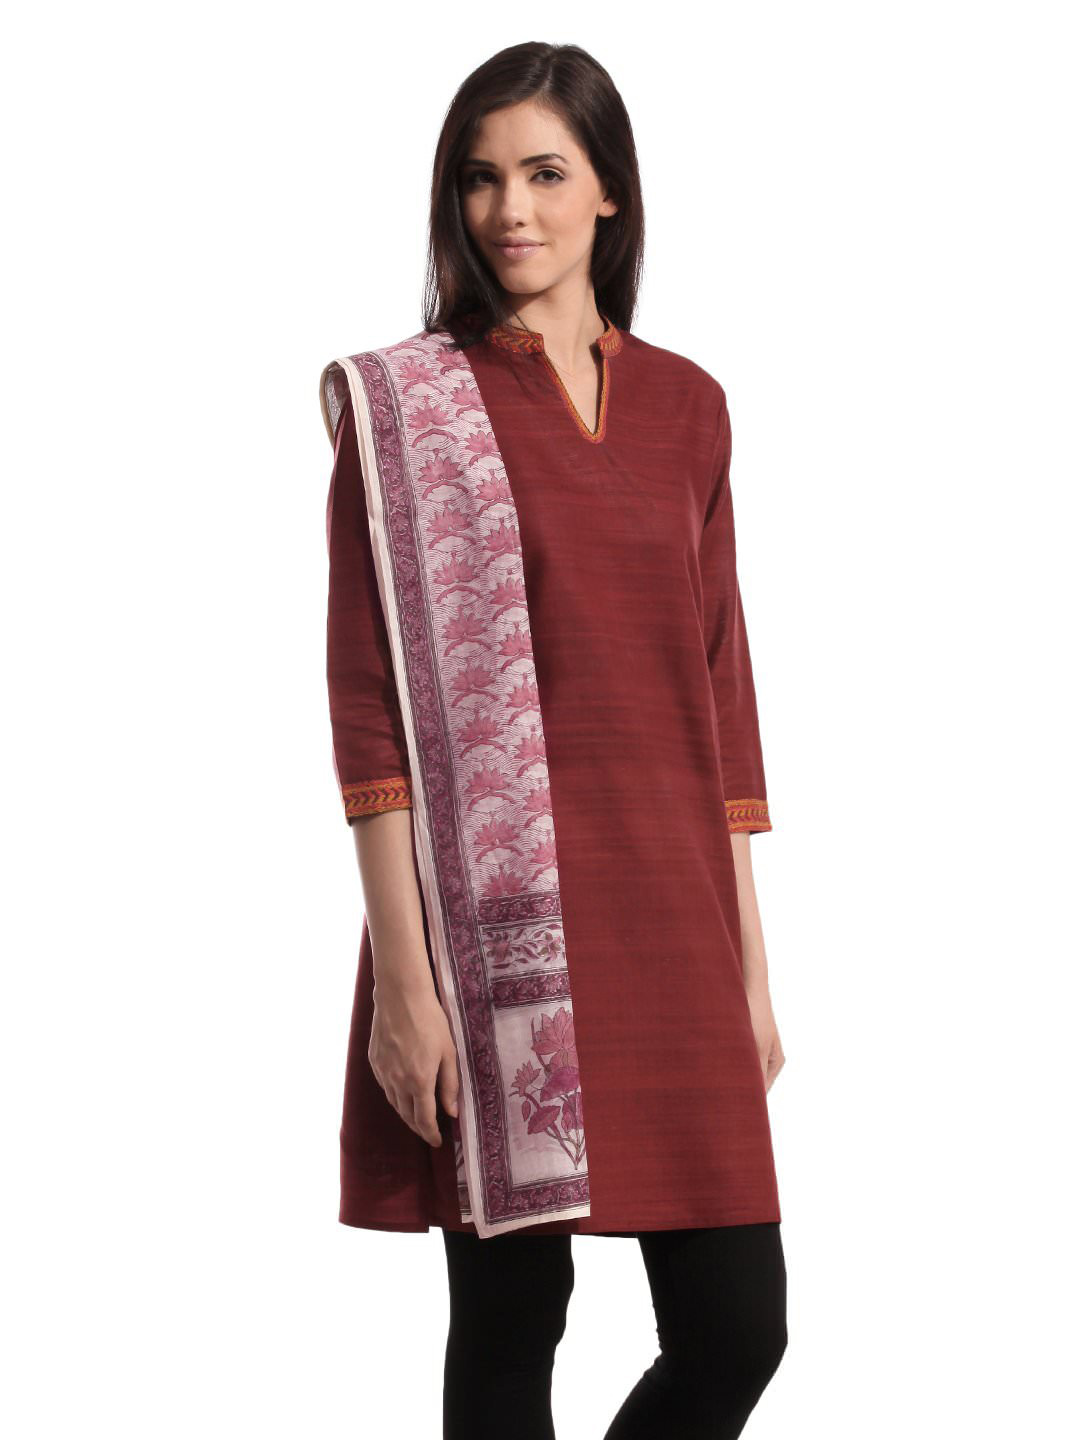

Product ID: 49700, Product Name: Park Avenue Men Navy Blue Tie


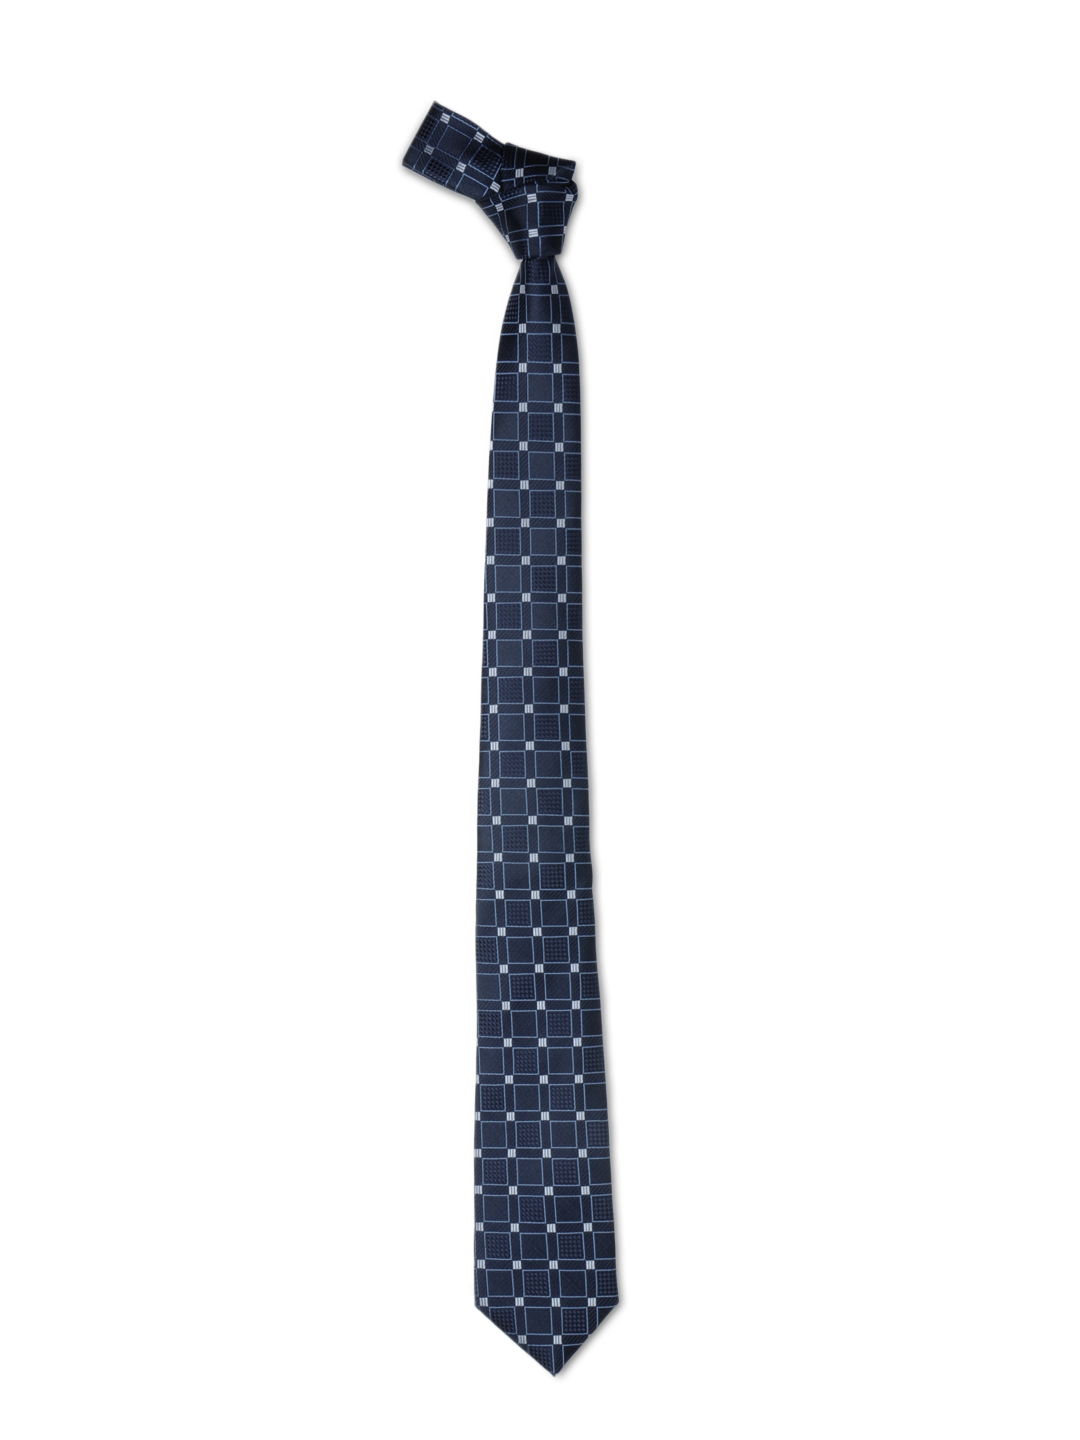

Product ID: 39139, Product Name: Aneri Women White & Black Printed Salwar Suit


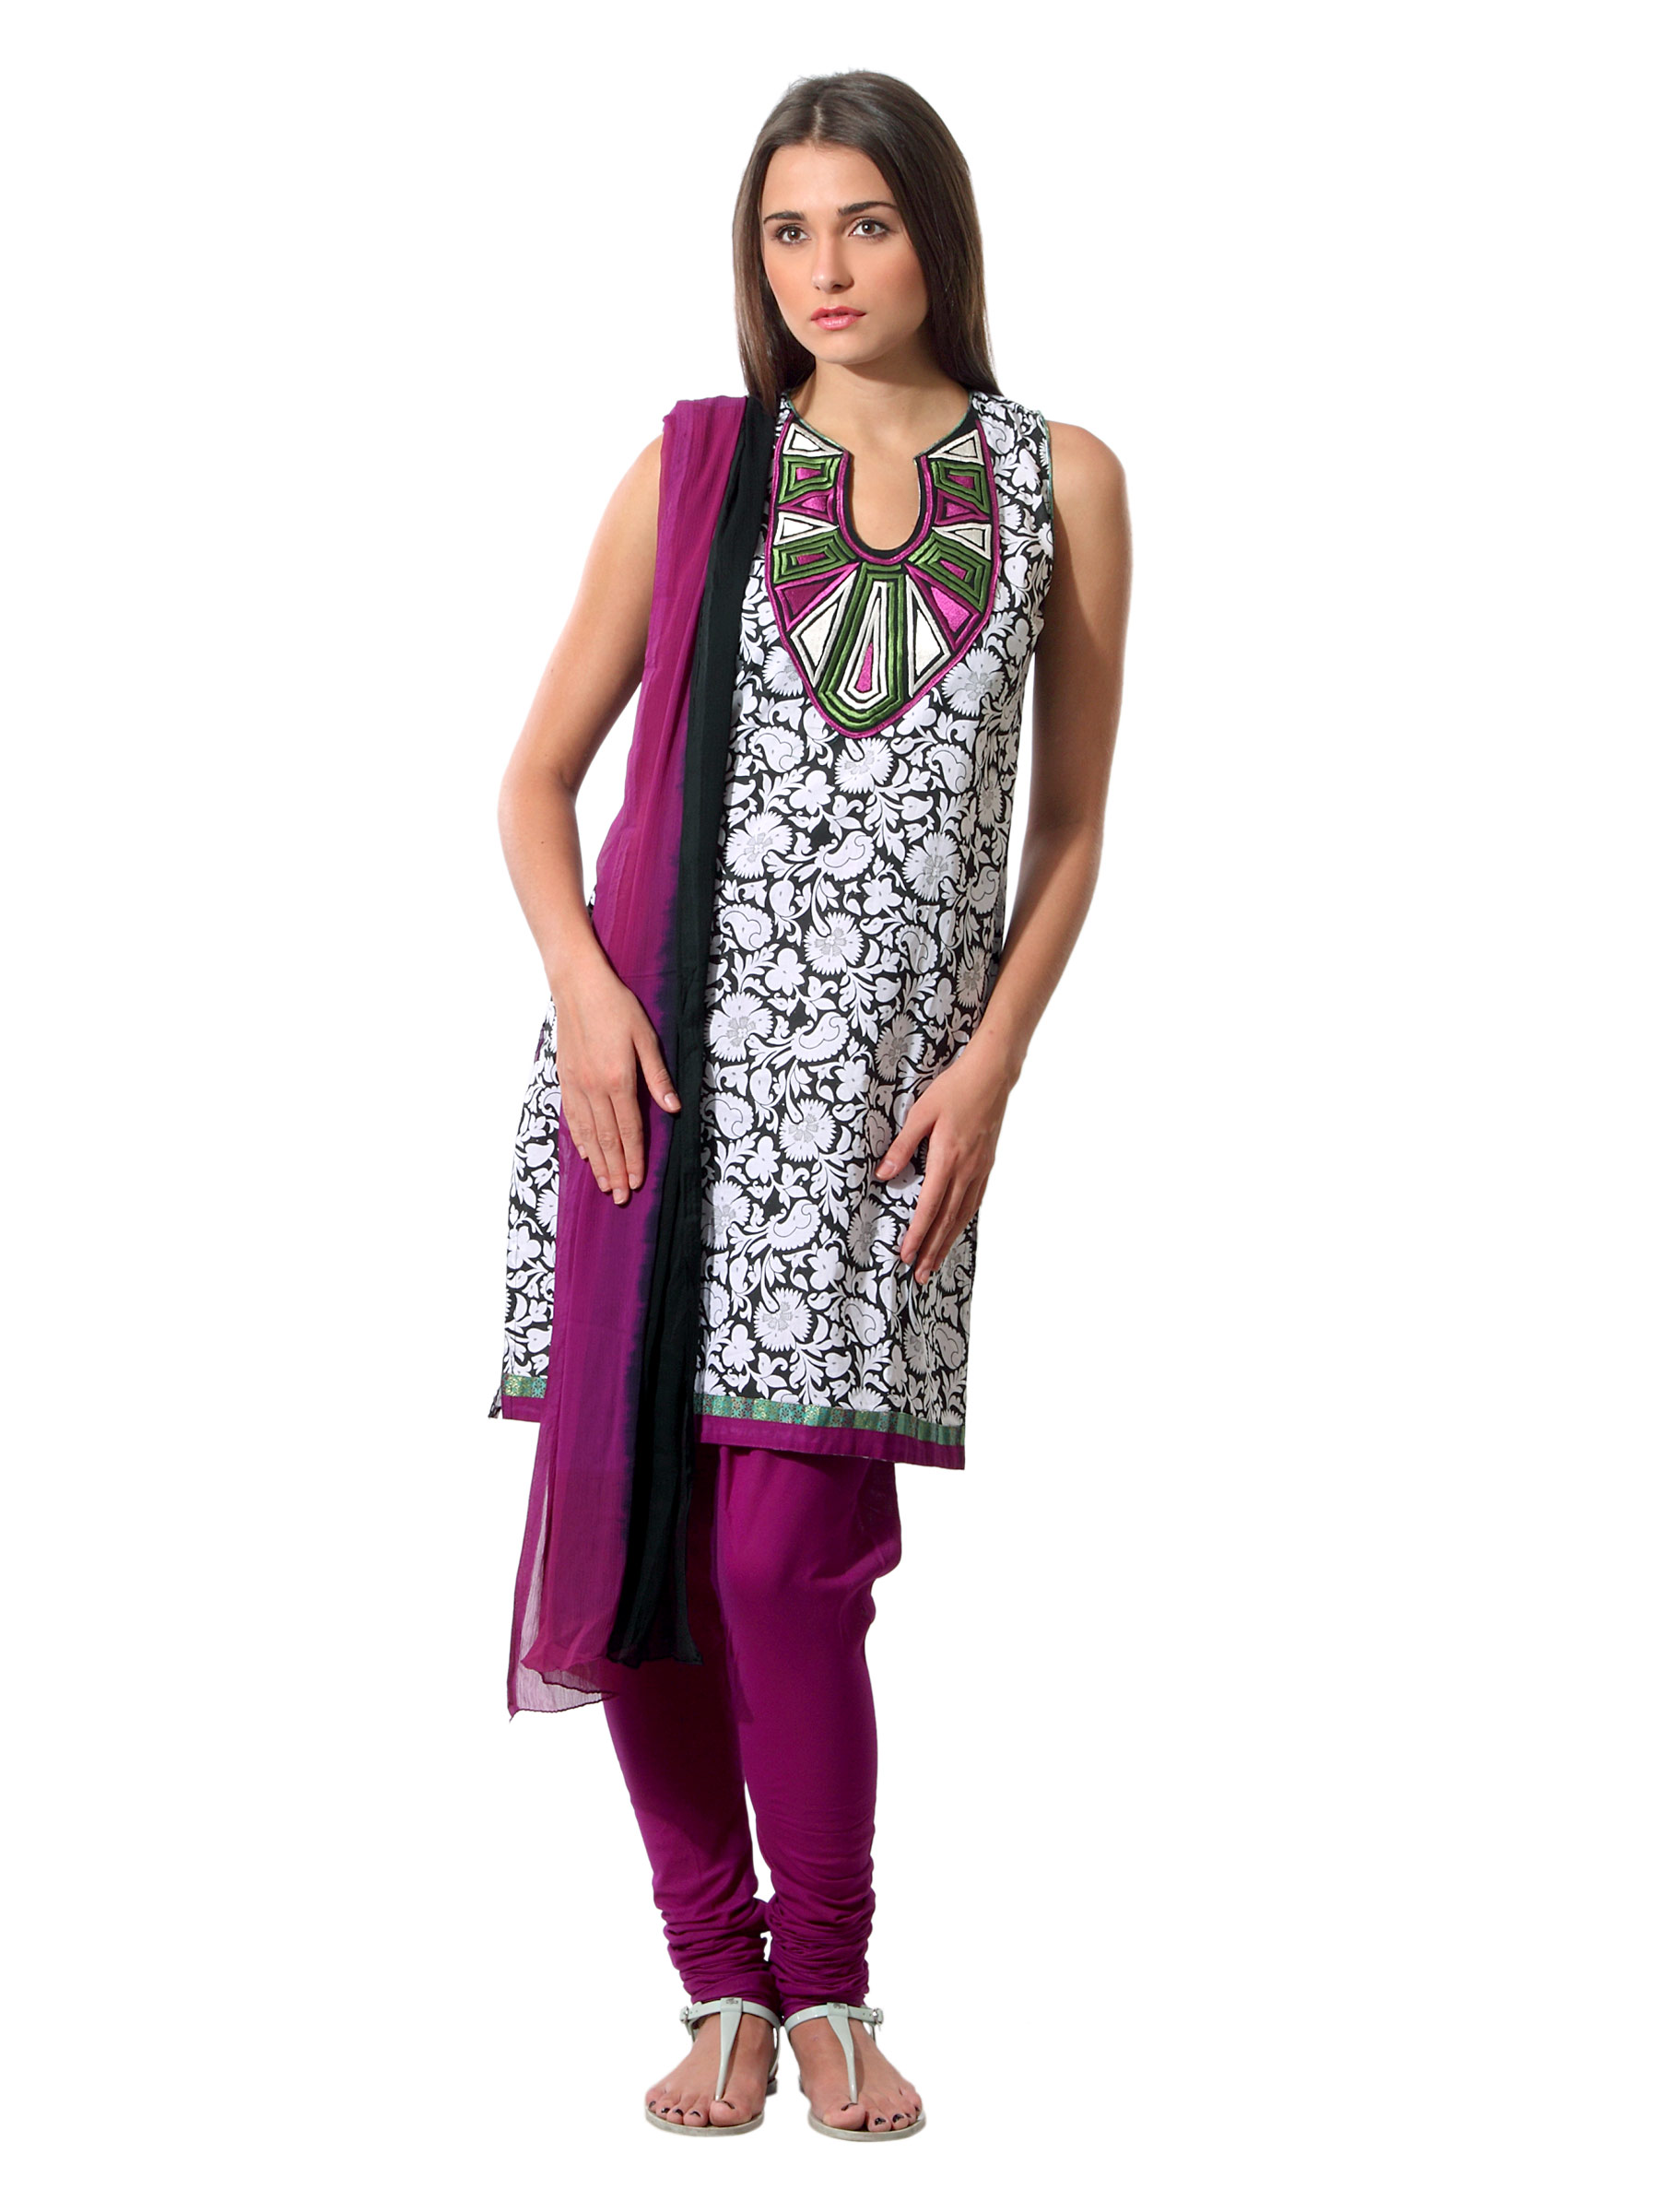

Product ID: 30923, Product Name: Fabindia Women Printed Mustard Skirt


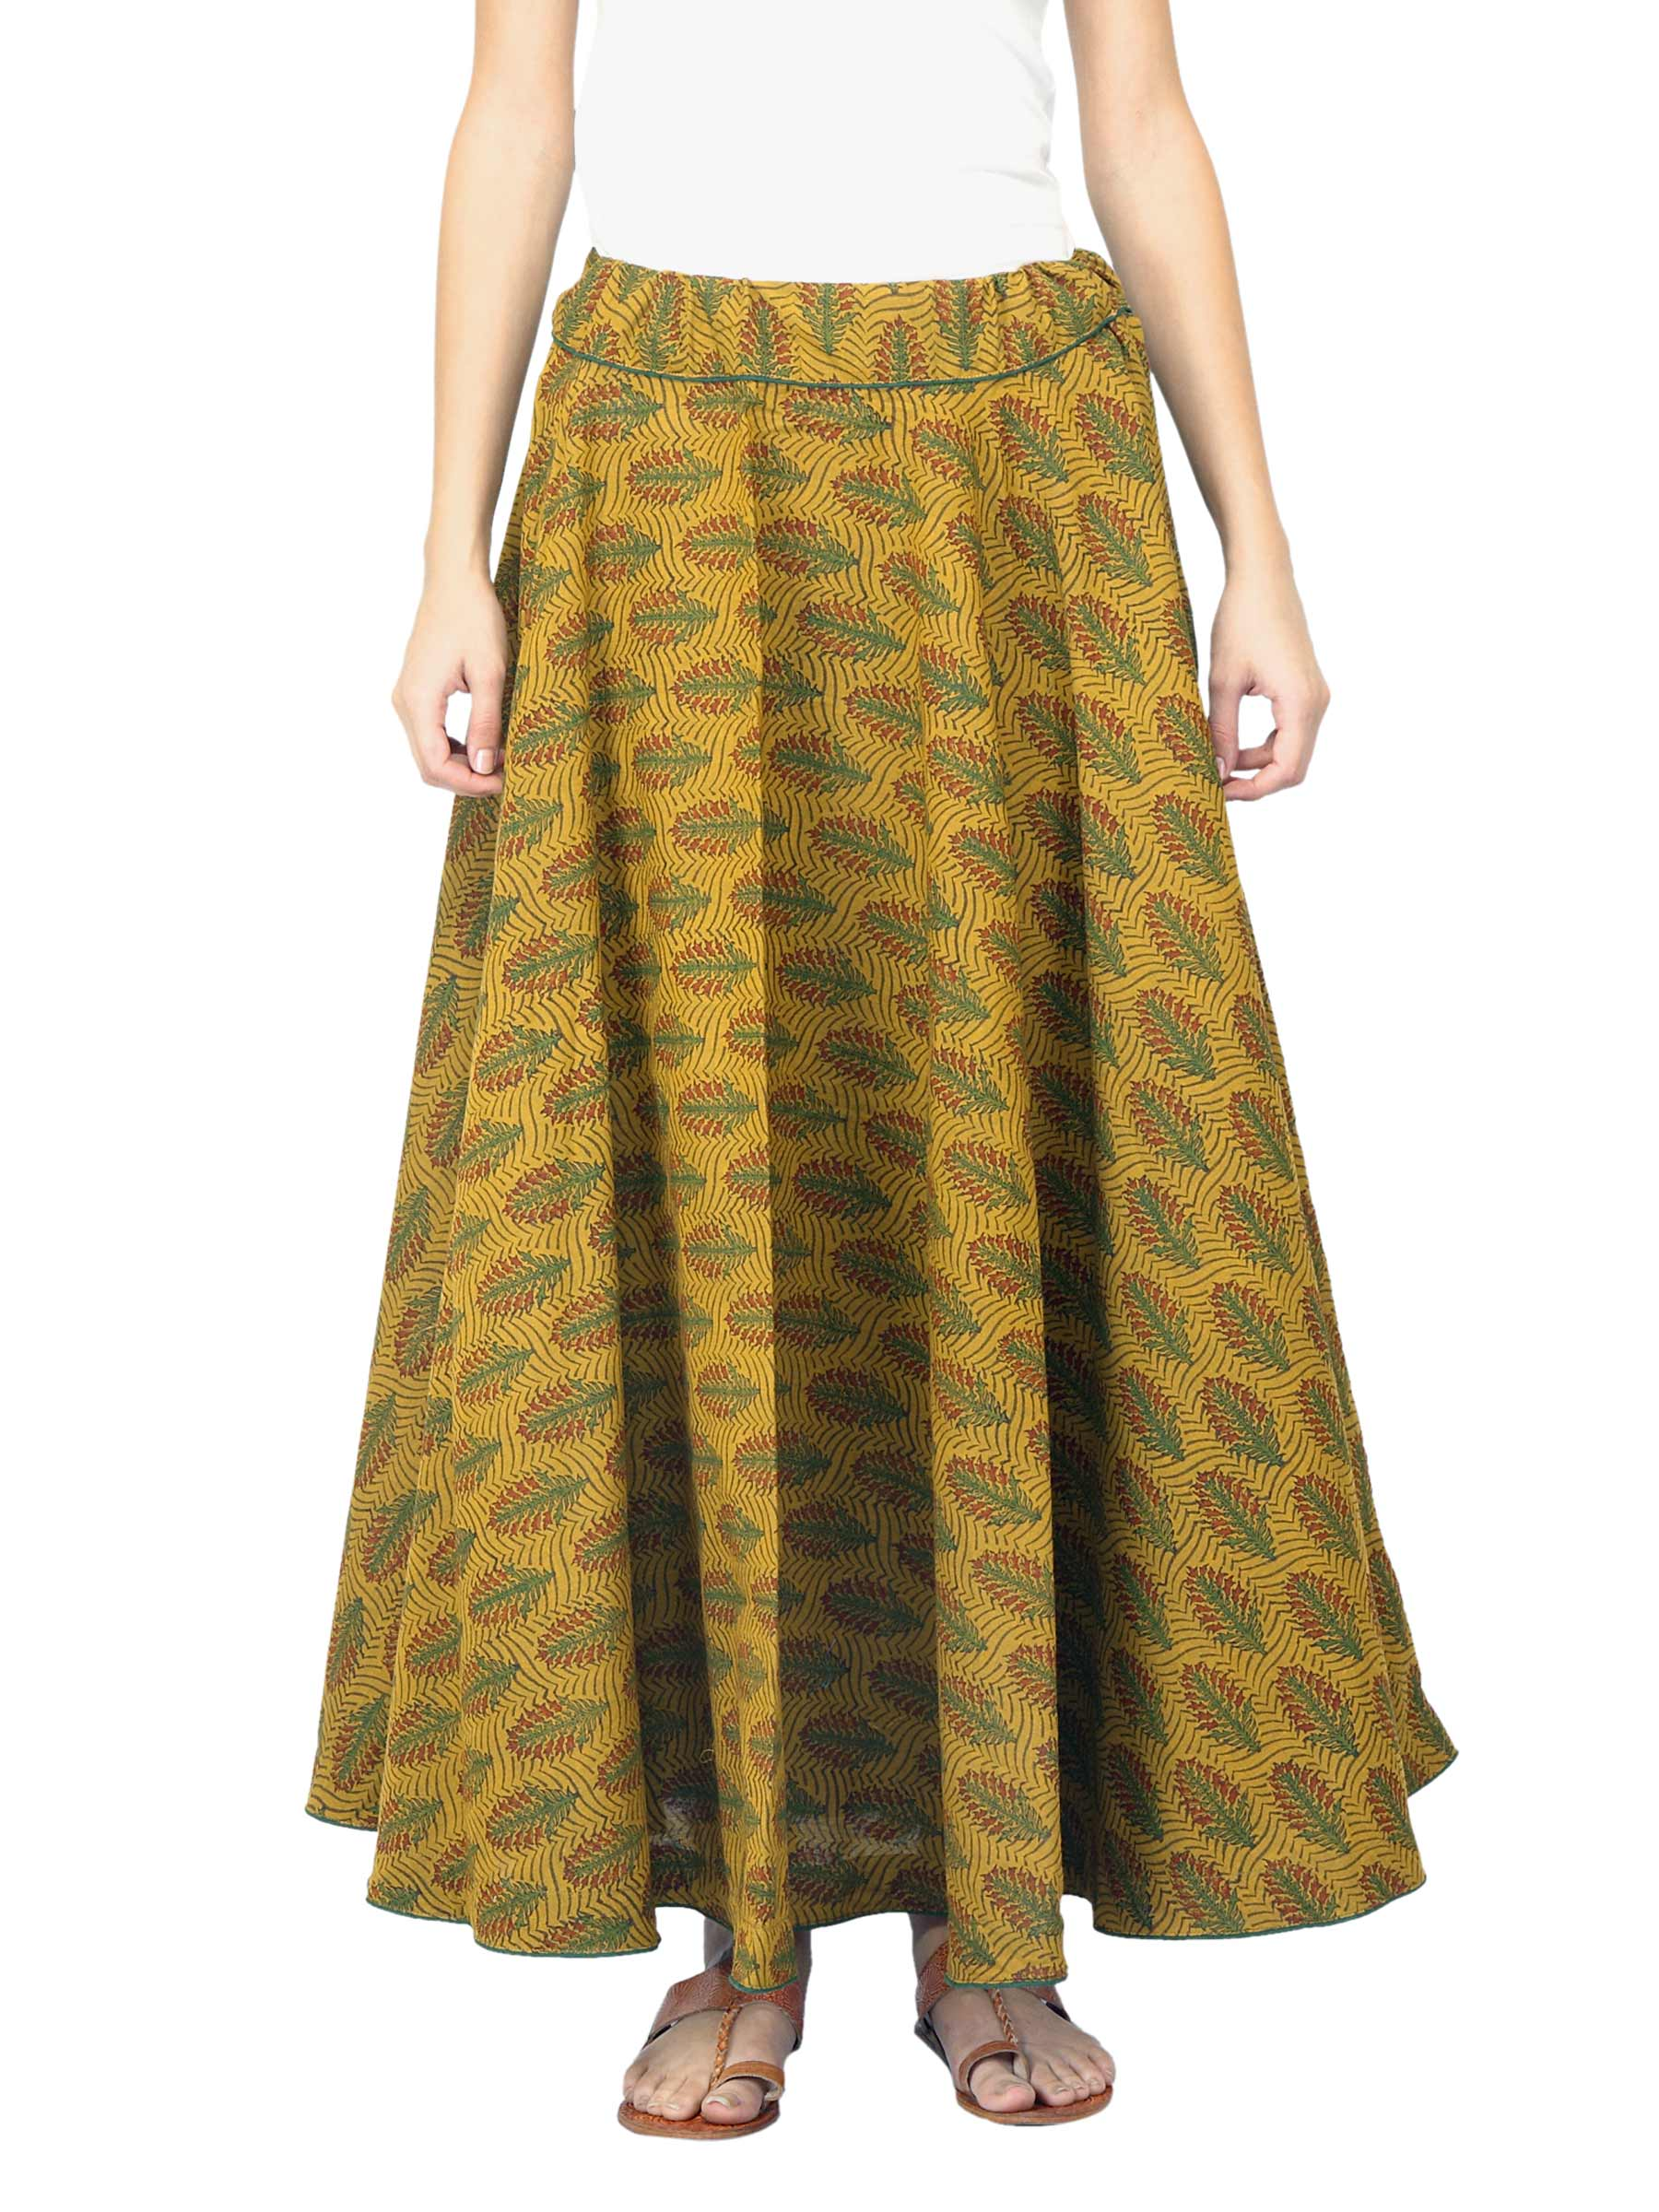

Product ID: 52990, Product Name: FNF Multi Coloured Sari


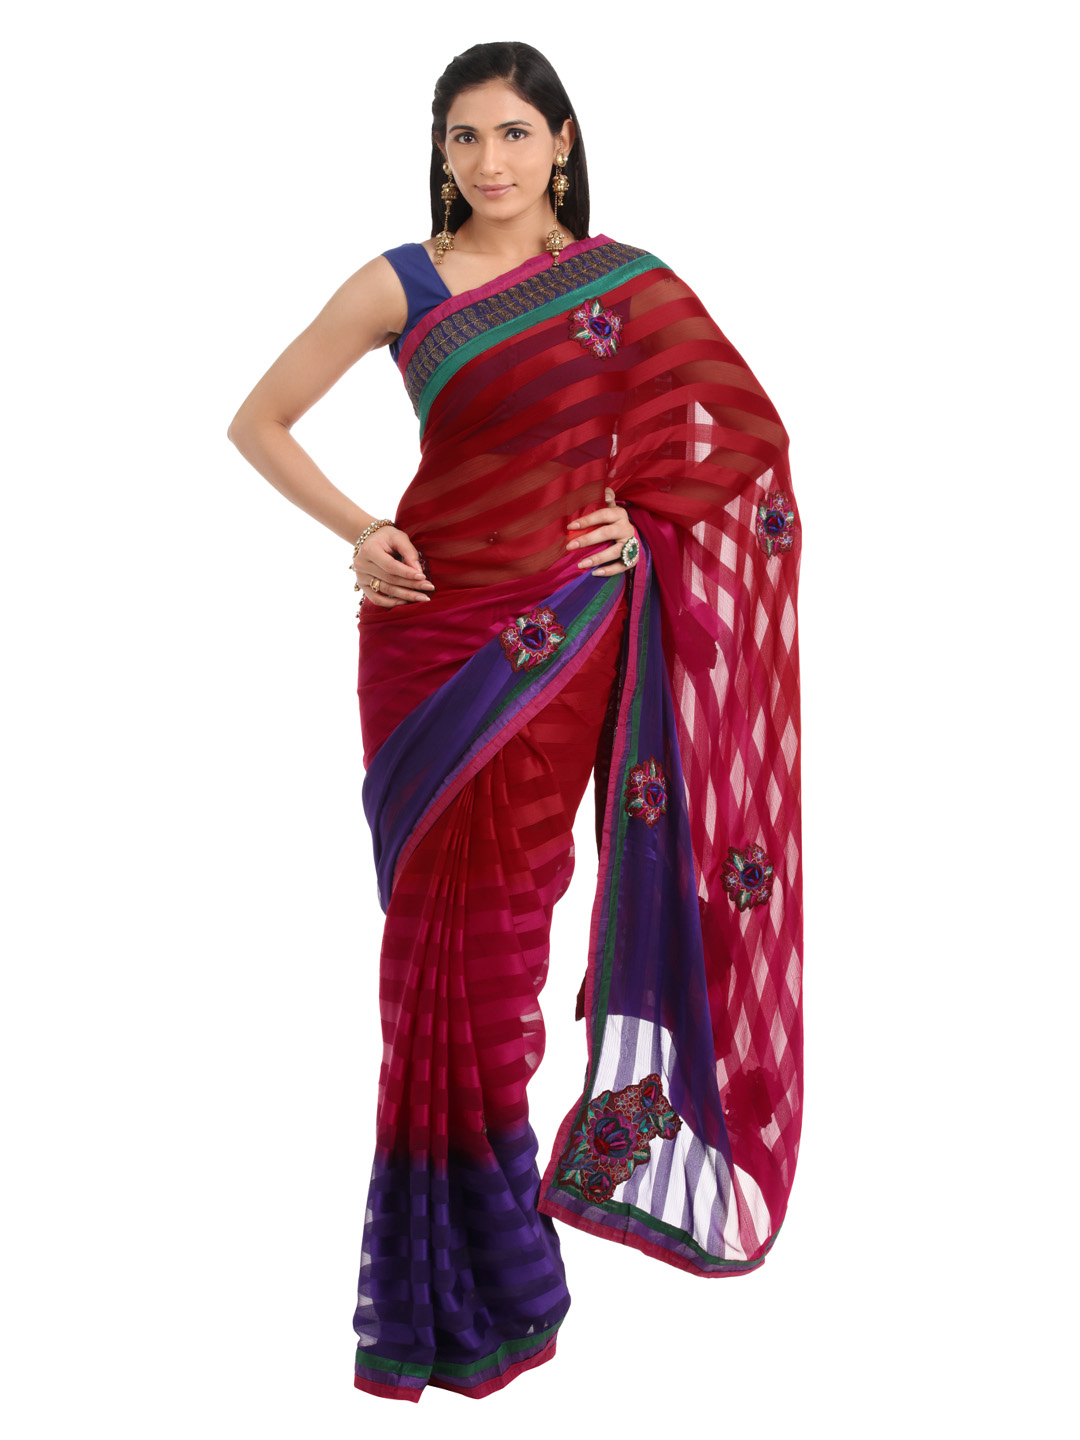

Product ID: 30738, Product Name: Fabindia Men Navy Blue Bhagalpur Nehru Jacket


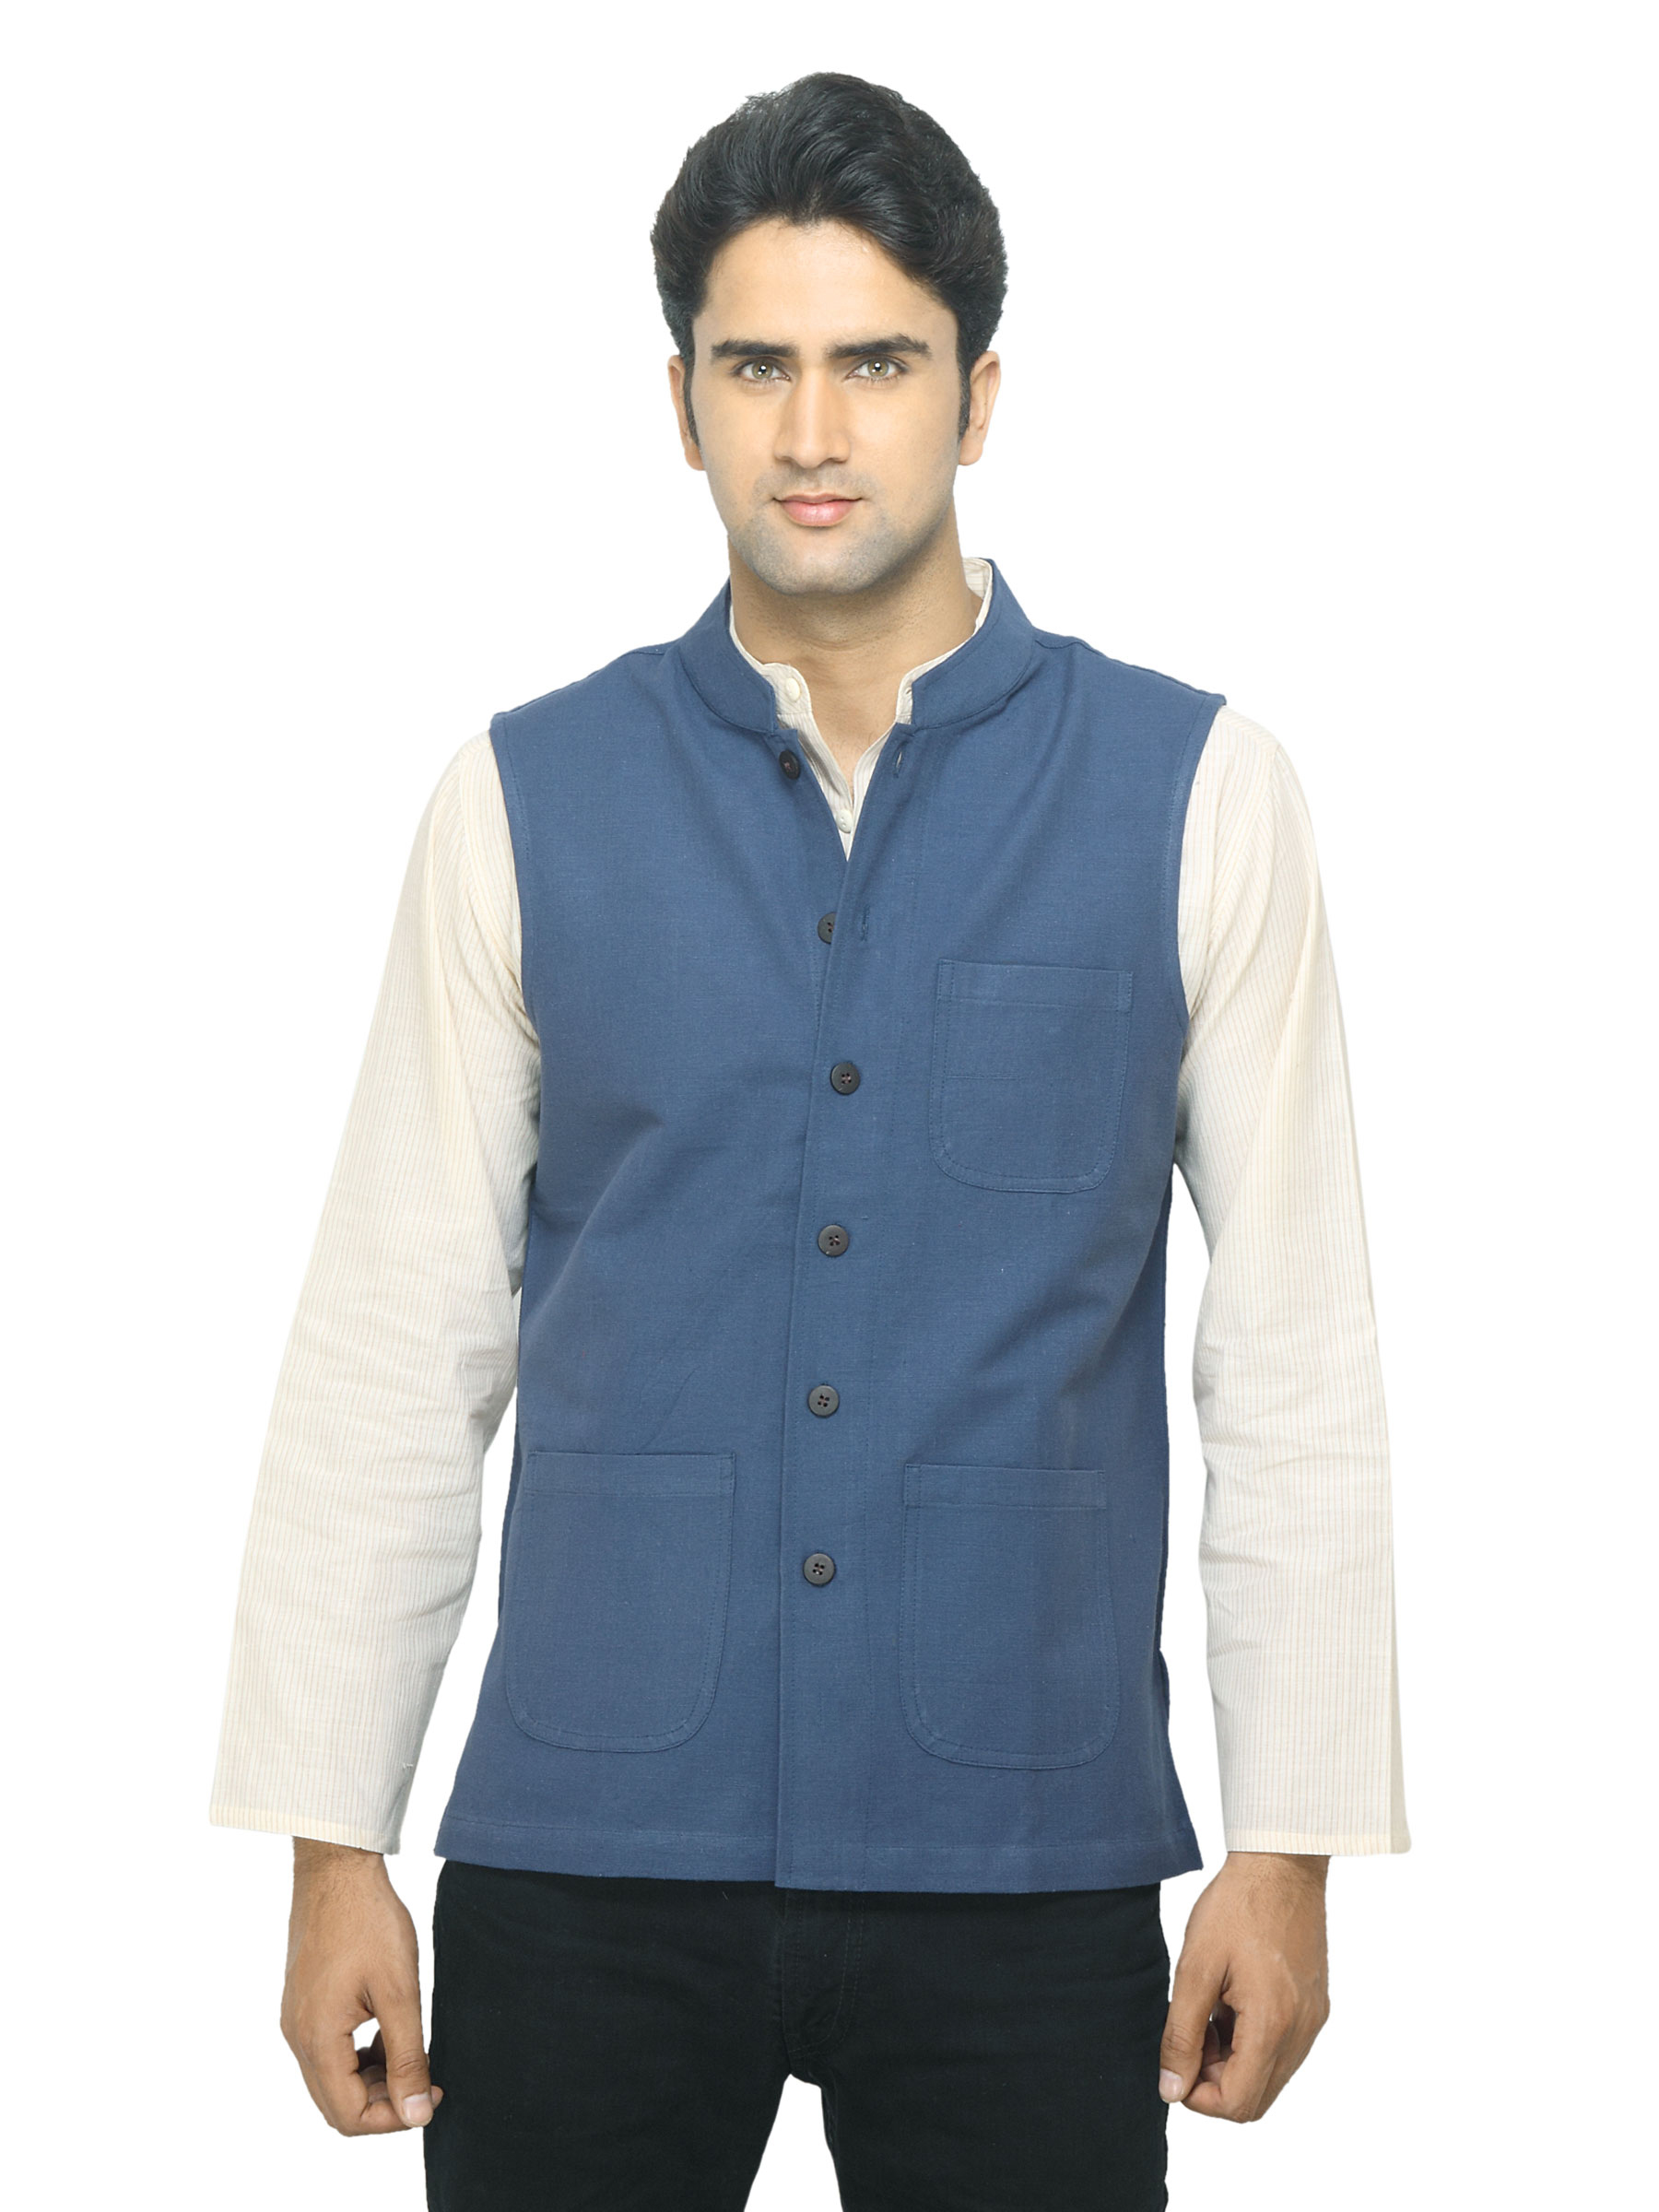

In [16]:
from IPython.display import Image, display

# Display images for the top 10 recommendations
for idx, row in recommendations.iterrows():
    if idx < 10:  # Ensure only top 10 are displayed
        print(f"Product ID: {row['id']}, Product Name: {row['productDisplayName']}")
        image_path = os.path.join('/kaggle/input/fashion-product-images-dataset/fashion-dataset/images', f"{row['id']}.jpg")
        display(Image(image_path))
